In [1]:
!pip install h5py

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize, curve_fit
from scipy.special import expit
import warnings

In [3]:
stop_correct_BHV_CS_df=pd.read_csv('stop_correct_BHV_CS.csv')
stop_wrong_BHV_WS_df=pd.read_csv('stop_wrong_BHV_WS.csv')
nostop_BHV_GO_df=pd.read_csv('nostop_BHV_GO.csv')

The behavioral analysis we are about to conduct is based on the race model as presented in the paper by Candelori et al., so we will calculate a P(response) curve based on the SSDs and we will plot it over the distribution of the Go trials, then we will integrate and subtract the SSD in order to calculate the SSRT, a variable that describes the speed of the inibitory processes that stop movement.

In order to produce a suitable P(Responde|SSD) equation we can use two methods :
-one is a simple algebric method that estimates the parameters in the general equation of a sigmoid curve from the raw data
-the other method looks to minimize the inverse of the log of the maximum likelihood binomial equation
We will attempt both

In [4]:
warnings.filterwarnings('ignore')
#Let's define the data by picking the two features that interest us and combining it across the datasets involving the correct stop and the wrong stop
SSD_stop_correct=stop_correct_BHV_CS_df[['StopSignal(s)','TrialNumber']]
SSD_stop_wrong=stop_wrong_BHV_WS_df[['StopSignal(s)','TrialNumber']]
#Now we add the labels by adding an additional column to the DataFrame that describes the original DataFrame of the data 
SSD_stop_correct['Result']='CS'
SSD_stop_wrong['Result']='WS'
SSD_combined=pd.concat([SSD_stop_correct,SSD_stop_wrong],ignore_index=True)
SSD_combined_df=pd.DataFrame(SSD_combined)
SSD_combined_df['Result']=SSD_combined_df['Result'].map({"WS":1,"CS":0})
SSD_combined_df

,StopSignal(s),TrialNumber,Result
0,0.313467,19.0,0
1,0.413655,27.0,0
2,0.514048,31.0,0
3,0.313344,72.0,0
4,0.313467,90.0,0
...,...,...,...
189,0.514826,981.0,1
190,0.514540,991.0,1
191,0.514744,997.0,1
192,0.414065,999.0,1


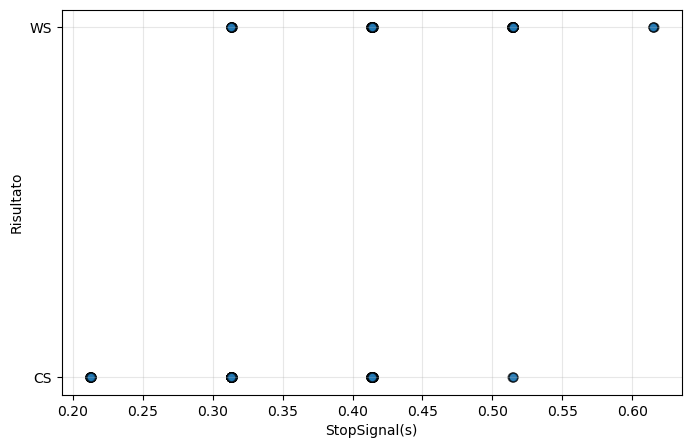

In [5]:
plt.figure(figsize=(8,5))
plt.scatter(SSD_combined_df["StopSignal(s)"], SSD_combined_df["Result"],
            alpha=0.6, edgecolor='k', s=40)
plt.xlabel("StopSignal(s)")
plt.ylabel("Risultato")
plt.yticks([0,1], ["CS","WS"])
plt.grid(alpha=0.3)
plt.show() 

In [11]:
def empirical_distribution(df, ssd_col="StopSignal(s)", result_col="Result"):
    grouped=(
        df.groupby(ssd_col)[result_col]
        .agg(["mean","count"])
        .reset_index()
        .rename(columns={"mean":"p_response","count":"n_trials"})
    )
    return grouped

def logistic(x,a,b):
    return 1/(1+np.exp(-(x-a)/b)) 

def fit_logistic(df,ssd_col="StopSignal(s)", result_col="Result"):
    x=df[ssd_col].values
    y=df[result_col].values
    popt,_=curve_fit(logistic,x,y,p0=[np.median(x),50])
    return popt

def bootstrap_logistic(df,n_boot=100, ssd_grid=None, ssd_col="StopSignal(s)", result_col="Result"):
    if ssd_grid is None:
        ssd_grid=np.linspace (df[ssd_col].min(),df[ssd_col].max(), 50)
    curves=[]
    for _ in range(n_boot):
        df_resample=df.sample(frac=1, replace=True)
        try:
            a,b=fit_logistic(df_resample,ssd_col, result_col)
            curves.append(logistic(ssd_grid,a,b))
        except RuntimeError:
            continue
            
    curves=np.array(curves)
    lower=np.percentile(curves,2.5,axis=0)
    upper=np.percentile(curves,97.5, axis=0)
    mean=np.mean(curves,axis=0)
    return ssd_grid, mean, lower, upper
                              

In [12]:
a_hat, b_hat=fit_logistic(SSD_combined_df)
ssd_grid,mean_curve,lower, upper=bootstrap_logistic(SSD_combined_df)

<function matplotlib.pyplot.show(close=None, block=None)>

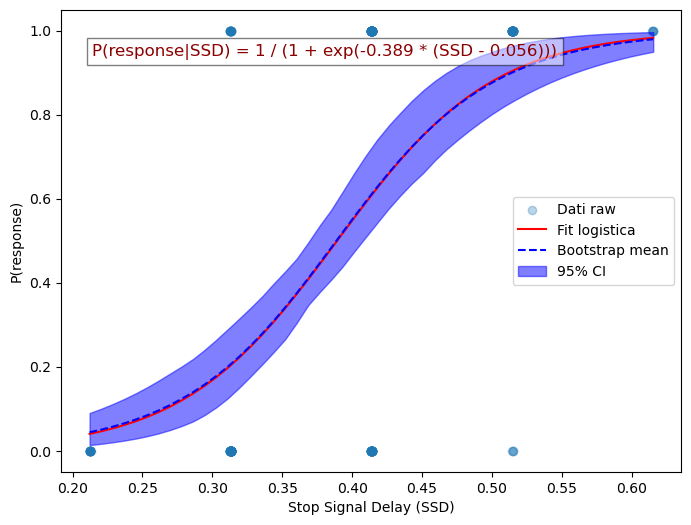

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(SSD_combined_df["StopSignal(s)"],SSD_combined_df["Result"],alpha=0.3, label="Dati raw")
plt.plot(ssd_grid, logistic(ssd_grid, a_hat, b_hat), "r-", label="Fit logistica")
plt.plot(ssd_grid, mean_curve, "b--", label="Bootstrap mean")
plt.fill_between(ssd_grid, upper, lower, color="blue", alpha=0.5, label="95% CI")
equation_text = f"P(response|SSD) = 1 / (1 + exp(-{a_hat:.3f} * (SSD - {b_hat:.3f})))"
plt.text(0.05, 0.9, equation_text, transform=plt.gca().transAxes,
         fontsize=12, color="darkred", bbox=dict(facecolor="white", alpha=0.5))
plt.xlabel("Stop Signal Delay (SSD)")
plt.ylabel("P(response)")
plt.legend()
plt.show